# W266 Final Project Modeling
## 1. Setup

In [ ]:
# Import libraries
!pip install gensim==3.8.3 --quiet

from google.colab import files
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import nltk
from nltk.data import find
import gensim

In [ ]:
# Read the data
uploaded = files.upload()

Saving top_30_emotes.csv to top_30_emotes.csv


<ipython-input-2-0e9d2710a7dd>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))
df.rename(columns={"label": "label_name"}, inplace=True)
df.head(5)

<ipython-input-128-5366ad058dd5>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))


,commenter_id,commenter_name,user_type,message_time,message_type,streamer,video_date,video_id,message_length,message,input,label_name
0,23261972.0,qrass,User,2023-03-11T18:05:21.218Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,3,no skipper stream Sadge,no skipper stream,Sadge
1,160455408.0,moby_drip,User,2023-03-11T18:05:42.405Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,3 second skippy stream Pog,3 second skippy stream,Pog
2,39897326.0,charmiee,User,2023-03-11T18:06:01.633Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,8,u got the wrong channel at first mate LUL,u got the wrong channel at first mate,LUL
3,115717981.0,just__ok,User,2023-03-11T18:06:31.622Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,Sadge not at streamer awards,not at streamer awards,Sadge
4,28841240.0,Karaszan,User,2023-03-11T18:06:53.793Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,10,Is it real this time? @sodapoppin :D No Stream...,Is it real this time? @sodapoppin :D No Stream...,Sadge


In [ ]:
df.groupby('streamer')['video_id'].nunique().sort_values(ascending=False)[:10]

streamer
esl_csgo           18
xqc                18
hasanabi           17
fextralife         17
rainbow6           16
forsen             16
nmplol             16
clix               16
tsm_imperialhal    16
summit1g           15
Name: video_id, dtype: int64

In [ ]:
streamer_counts = df[['streamer']].groupby(['streamer'])['streamer'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
print('Number of streamers:', len(streamer_counts))
print('Average messages per streamer:', streamer_counts["count"].mean())
streamer_counts

Number of streamers: 93
Average messages per streamer: 9234.086021505376


,streamer,count
27,forsen,92871
43,lec,82374
33,hasanabi,66891
88,xqc,53476
38,kaicenat,52015
...,...,...
20,eamaddennfl,89
84,unboxholics,88
17,cxmmunity,59
5,brawlhalla,32


In [ ]:
emote_counts = df[['label_name']].groupby(['label_name'])['label_name'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
emote_counts

,label_name,count
9,KEKW,184087
12,LUL,177796
18,Pog,61591
22,Sadge,46814
7,FeelsBadMan,36106
10,Kappa,28720
8,FeelsGoodMan,28670
16,PepeLaugh,26186
26,YEP,22640
20,PogU,20375


In [ ]:
df = pd.merge(df, emote_counts, on="label_name")

In [ ]:
# Lower case input column
df['input'] = df['input'].str.lower()

In [ ]:
# String index the label names
le = LabelEncoder()
df['label'] = le.fit_transform(df['label_name'])

# You can reverse this encoding: le.inverse_transform([9, 10, 1, 2])
# range(30)
print(le.inverse_transform(range(30)))

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [ ]:
messages = df.input
labels = df.label
# Split into train & test
train_texts, test_texts, train_labels, test_labels = train_test_split(messages, labels, test_size=0.1, random_state=123)
print(len(train_texts))
print(len(test_texts))

772893
85877


In [ ]:
train_texts[:5]

210280    extendo42012 went all in and lost every single...
706028     clap  clap  clap  clap  clap  clap  clap  cla...
766991                                     pimp my rl ride 
242967                                 everyone else stink?
345423    ricathegoat_ lost 69 points in roulette and no...
Name: input, dtype: object

In [ ]:
train_labels[:5]

210280    12
706028    27
766991    20
242967    12
345423     7
Name: label, dtype: int64

Let's explicitly set aside part of our training set for validation purposes.



In [ ]:
# Validation split is about 90/10 split
valid_texts = train_texts[700000:] 
valid_labels = train_labels[700000:]
train_texts = train_texts[:700000]
train_labels = train_labels[:700000]

print(len(train_texts)) # Always 500,000
print(len(valid_texts)) # 72893 until we change emotes

700000
72893


In [ ]:
# Get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

## 2. Baseline Model (Majority Class)

In [ ]:
majority = train_labels.mode()[0]
print('Majority class:', majority)
print('Majority class name:', le.inverse_transform([majority]))
# train_labels.value_counts()

Majority class: 9
Majority class name: ['KEKW']


In [ ]:
# Predict for train
test_predictions = np.empty(len(test_texts))
test_predictions.fill(majority)

In [ ]:
# Compare the first 5 predictions
test_compare = pd.DataFrame(test_labels.copy())
test_compare['prediction'] = test_predictions.astype(int)
test_compare.head(5)

,label,prediction
73238,18,9
195589,12,9
318182,7,9
149611,12,9
594304,16,9


In [ ]:
print(le.inverse_transform(range(30)))

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [ ]:
print(classification_report(test_labels, test_predictions))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       983
           1       0.00      0.00      0.00       482
           2       0.00      0.00      0.00       490
           3       0.00      0.00      0.00      1863
           4       0.00      0.00      0.00      1419
           5       0.00      0.00      0.00       904
           6       0.00      0.00      0.00       792
           7       0.00      0.00      0.00      3691
           8       0.00      0.00      0.00      2816
           9       0.21      1.00      0.35     18314
          10       0.00      0.00      0.00      2933
          11       0.00      0.00      0.00      1105
          12       0.00      0.00      0.00     17721
          13       0.00      0.00      0.00      1778
          14       0.00      0.00      0.00      1670
          15       0.00      0.00      0.00       855
          16       0.00      0.00      0.00      2656
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Model 1: LSTM

In [ ]:

# Get word2vec model from nltk
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

len(model.vocab)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


43981

In [ ]:
# Build embedding matrix and vocab dictionary
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

(43982, 300)

In [ ]:
# !pip install tensorflow_text --quiet
import tensorflow_text as tf_text

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
test_tokens = tokenizer.tokenize(test_texts)

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'huh', b'.oo', b'(', b')'], dtype=object)>

In [ ]:
MAX_SEQUENCE_LENGTH = 10

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [ ]:
train_tokens = train_tokens[:200000] ### TODO: REMOVE THIS AFTER TESTING
test_tokens = test_tokens[:50000] ### TODO: REMOVE THIS AFTER TESTING

train_labels = train_labels[:200000] ### TODO: REMOVE THIS AFTER TESTING
test_labels = test_labels[:50000] ### TODO: REMOVE THIS AFTER TESTING

train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000


KeyboardInterrupt: ignored

In [ ]:
train_tokens[:5]

In [ ]:
train_input[:5]

array([[20190, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981],
       [16909, 43981, 16724,  3638, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981],
       [43981,  1982, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981],
       [43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981],
       [43981, 16908, 15435, 39933, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981]])

In [ ]:
from tensorflow.keras.layers import Embedding

def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

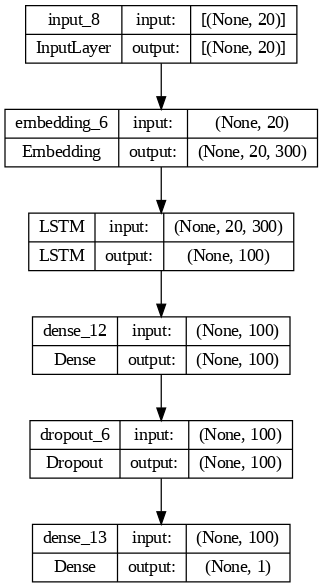

In [ ]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [ ]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
6250/6250 [==============================] - 170s 27ms/step - loss: -1103197.5000 - accuracy: 0.0057 - val_loss: -3037184.0000 - val_accuracy: 0.0055
Epoch 2/5
6250/6250 [==============================] - 167s 27ms/step - loss: -6273091.0000 - accuracy: 0.0057 - val_loss: -10164700.0000 - val_accuracy: 0.0055
Epoch 3/5
6250/6250 [==============================] - 180s 29ms/step - loss: -15244376.0000 - accuracy: 0.0057 - val_loss: -20971744.0000 - val_accuracy: 0.0055
Epoch 4/5
6250/6250 [==============================] - 167s 27ms/step - loss: -27840046.0000 - accuracy: 0.0057 - val_loss: -35391864.0000 - val_accuracy: 0.0055
Epoch 5/5
6250/6250 [==============================] - 169s 27ms/step - loss: -44007272.0000 - accuracy: 0.0057 - val_loss: -53380124.0000 - val_accuracy: 0.0055


In [ ]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 [==============================] - 86s 134ms/step - loss: -17014.2578 - accuracy: 0.0063 - val_loss: -48961.5312 - val_accuracy: 0.0062
Epoch 2/5
625/625 [==============================] - 73s 117ms/step - loss: -111089.9609 - accuracy: 0.0062 - val_loss: -183326.7656 - val_accuracy: 0.0062
Epoch 3/5
625/625 [==============================] - 76s 121ms/step - loss: -283614.2812 - accuracy: 0.0062 - val_loss: -388096.0625 - val_accuracy: 0.0062
Epoch 4/5
625/625 [==============================] - 81s 130ms/step - loss: -522027.9375 - accuracy: 0.0062 - val_loss: -653189.1875 - val_accuracy: 0.0062
Epoch 5/5
625/625 [==============================] - 78s 125ms/step - loss: -819404.3125 - accuracy: 0.0062 - val_loss: -971757.1875 - val_accuracy: 0.0062


In [ ]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()